# week7 solutions
### Peilin Luo

In [30]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, minimize
from sklearn import linear_model
from riskill import risk
import datetime

### problem 1

In [2]:
def gbsm(call:bool, underlying, strike, ttm, rf, b, ivol):
    d1 = (np.log(underlying/strike) + (b + ivol**2 / 2) * ttm) / (ivol * np.sqrt(ttm))
    d2 = d1 - ivol * np.sqrt(ttm)
    if call:
        return underlying*np.exp((b-rf)*ttm)*sps.norm.cdf(d1) - strike*np.exp(-rf*ttm)*sps.norm.cdf(d2)
    elif not call:
        return strike*np.exp(-rf*ttm)*sps.norm.cdf(-d2) - underlying*np.exp((b-rf)*ttm)*sps.norm.cdf(-d1)
    else:
        raise ValueError("call must be True or False")

In [3]:
def bt_american(call:bool, underlying, strike, ttm, rf, b, ivol, N):
    dt = ttm/N
    u = np.exp(ivol*np.sqrt(dt))
    d = 1/u
    pu = (np.exp(b*dt)-d)/(u-d)
    pdown = 1. - pu
    df = np.exp(-rf*dt)
    z = 1 if call else -1

    def nNodeFunc(n):
        return int((n+1)*(n+2)/2)

    def idxFunc(i, j):
        return int(nNodeFunc(j-1)+i)

    nNodes = nNodeFunc(N)
    optionValues = np.zeros(nNodes)

    for j in range(N, -1, -1):
        for i in range(j, -1, -1):
            idx = idxFunc(i, j)
            price = underlying * u**i * d**(j-i)
            optionValues[idx] = max(0, z*(price-strike))

            if j < N:
                optionValues[idx] = max(optionValues[idx], df*(pu*optionValues[idxFunc(i+1, j+1)]+pdown*optionValues[idxFunc(i, j+1)]))

    return optionValues[0]

In [4]:
def bt_american_with_div(call:bool, underlying, strike, ttm, rf, divAmts:list, divTimes:list, ivol, N):
    if not (len(divAmts) and len(divTimes)):
        return bt_american(call, underlying, strike, ttm, rf, rf, ivol, N)
    elif divTimes[0] > N:
        return bt_american(call, underlying, strike, ttm, rf, rf, ivol, N)

    dt = ttm/N
    u = np.exp(ivol*np.sqrt(dt))
    d = 1/u
    pu = (np.exp(rf*dt)-d)/(u-d)
    pdown = 1. - pu
    df = np.exp(-rf*dt)
    z = 1 if call else -1

    def nNodeFunc(n):
        return int((n+1)*(n+2)/2)

    def idxFunc(i, j):
        return int(nNodeFunc(j-1)+i)

    nNodes = nNodeFunc(divTimes[0])
    optionValues = np.zeros(nNodes)

    for j in range(divTimes[0], -1, -1):
        for i in range(j, -1, -1):
            idx = idxFunc(i, j)
            price = underlying * u**i * d**(j-i)

            if j < divTimes[0]:
                optionValues[idx] = max(0, z*(price-strike))
                optionValues[idx] = max(optionValues[idx], df*(pu*optionValues[idxFunc(i+1, j+1)] + pdown*optionValues[idxFunc(i, j+1)]))
            else:
                # time of dividend (recursively)
                valNoExercise = bt_american_with_div(call, price-divAmts[0], strike, ttm-divTimes[0]*dt, rf, divAmts[1:], [x-divTimes[0] for x in divTimes[1:]], ivol, N-divTimes[0])
                valExercise = max(0, z*(price-strike))
                optionValues[idx] = max(valNoExercise, valExercise)

    return optionValues[0]

In [5]:
class Greeks:
    def __init__(self, call:bool, underlying, strike, ttm, rf, b, ivol,  N=None, divAmts:list=[], divTimes:list=[]):
        self._call = call
        self._underlying = underlying
        self._strike = strike
        self._ttm = ttm
        self._rf = rf
        self._b = b
        self._ivol = ivol
        self._N = N
        self._divAmts = divAmts
        self._divTimes = divTimes

    def d1(self):
        return (np.log(self._underlying/self._strike) + (self._b + self._ivol**2 / 2) * self._ttm) / (self._ivol * np.sqrt(self._ttm))

    def d2(self):
        return self.d1() - self._ivol * np.sqrt(self._ttm)

    def delta(self):
        """
        first derivative of value wrt underlying
        """
        if self._call:
            return np.exp((self._b - self._rf)*self._ttm) * sps.norm.cdf(self.d1())
        else:
            return np.exp((self._b - self._rf)*self._ttm) * (sps.norm.cdf(self.d1())-1)

    def delta_finite_dif(self, step:float):
        """
        first finite difference of value wrt underlying
        """
        if self._N is not None and len(self._divAmts) and len(self._divTimes):
            p1 = bt_american_with_div(self._call, self._underlying+step, self._strike, self._ttm, self._rf, self._divAmts, self._divTimes, self._ivol, self._N)
            p2 = bt_american_with_div(self._call, self._underlying-step, self._strike, self._ttm, self._rf, self._divAmts, self._divTimes, self._ivol, self._N)
        elif self._N is not None and not (len(self._divAmts) and len(self._divTimes)):
            p1 = bt_american(self._call, self._underlying+step, self._strike, self._ttm, self._rf, self._b, self._ivol, self._N)
            p2 = bt_american(self._call, self._underlying-step, self._strike, self._ttm, self._rf, self._b, self._ivol, self._N)
        else:
            p1 = gbsm(self._call, self._underlying+step, self._strike, self._ttm, self._rf, self._b, self._ivol)
            p2 = gbsm(self._call, self._underlying-step, self._strike, self._ttm, self._rf, self._b, self._ivol)

        return (p1-p2) / (2*step)

    def gamma(self):
        """
        second derivative of value wrt underlying (convexity)
        """
        nominator = np.exp((self._b - self._rf)*self._ttm) * sps.norm.pdf(self.d1())
        denominator = self._underlying*self._ivol*np.sqrt(self._ttm)
        return nominator / denominator

    def gamma_finite_dif(self, step:float):
        """
        second finite difference of value wrt underlying (convexity)
        """
        if self._N is not None and len(self._divAmts) and len(self._divTimes):
            p1 = bt_american_with_div(self._call, self._underlying+step, self._strike, self._ttm, self._rf, self._divAmts, self._divTimes, self._ivol, self._N)
            p2 = bt_american_with_div(self._call, self._underlying-step, self._strike, self._ttm, self._rf, self._divAmts, self._divTimes, self._ivol, self._N)
            p3 = bt_american_with_div(self._call, self._underlying, self._strike, self._ttm, self._rf, self._divAmts, self._divTimes, self._ivol, self._N)
        elif self._N is not None and not (len(self._divAmts) and len(self._divTimes)):
            p1 = bt_american(self._call, self._underlying+step, self._strike, self._ttm, self._rf, self._b, self._ivol, self._N)
            p2 = bt_american(self._call, self._underlying-step, self._strike, self._ttm, self._rf, self._b, self._ivol, self._N)
            p3 = bt_american(self._call, self._underlying, self._strike, self._ttm, self._rf, self._b, self._ivol, self._N)
        else:
            p1 = gbsm(self._call, self._underlying+step, self._strike, self._ttm, self._rf, self._b, self._ivol)
            p2 = gbsm(self._call, self._underlying-step, self._strike, self._ttm, self._rf, self._b, self._ivol)
            p3 = gbsm(self._call, self._underlying, self._strike, self._ttm, self._rf, self._b, self._ivol)

        return (p1+p2-2*p3) / (step**2)

    def vega(self):
        """
        first derivative of value wrt implied volatility
        """
        return self._underlying*np.exp((self._b - self._rf)*self._ttm)*sps.norm.pdf(self.d1())*np.sqrt(self._ttm)

    def vega_finite_dif(self, step:float):
        """
        first finite difference of value wrt implied volatility
        """
        if self._N is not None and len(self._divAmts) and len(self._divTimes):
            p1 = bt_american_with_div(self._call, self._underlying, self._strike, self._ttm, self._rf, self._divAmts, self._divTimes, self._ivol+step, self._N)
            p2 = bt_american_with_div(self._call, self._underlying, self._strike, self._ttm, self._rf, self._divAmts, self._divTimes, self._ivol-step, self._N)
        elif self._N is not None and not (len(self._divAmts) and len(self._divTimes)):
            p1 = bt_american(self._call, self._underlying, self._strike, self._ttm, self._rf, self._b, self._ivol+step, self._N)
            p2 = bt_american(self._call, self._underlying, self._strike, self._ttm, self._rf, self._b, self._ivol-step, self._N)
        else:
            p1 = gbsm(self._call, self._underlying, self._strike, self._ttm, self._rf, self._b, self._ivol+step)
            p2 = gbsm(self._call, self._underlying, self._strike, self._ttm, self._rf, self._b, self._ivol-step)
        return (p1-p2) / (2*step)

    def theta(self):
        """
        first derivative of value wrt ttm
        """
        p1 = -self._underlying*np.exp((self._b - self._rf)*self._ttm)*sps.norm.pdf(self.d1())*self._ivol / (2*np.sqrt(self._ttm))
        p2 = (self._b - self._rf)*self._underlying*np.exp((self._b - self._rf)*self._ttm)
        p3 = self._rf*self._strike*np.exp(-self._rf*self._ttm)
        if self._call:
            return p1-p2*sps.norm.cdf(self.d1())-p3*sps.norm.cdf(self.d2())
        else:
            return p1+p2*sps.norm.cdf(-self.d1())+p3*sps.norm.cdf(-self.d2())

    def theta_finite_dif(self, step:float):
        """
        first finite difference of value wrt ttm
        """
        if self._N is not None and len(self._divAmts) and len(self._divTimes):
            p1 = bt_american_with_div(self._call, self._underlying, self._strike, self._ttm+step, self._rf, self._divAmts, self._divTimes, self._ivol, self._N)
            p2 = bt_american_with_div(self._call, self._underlying, self._strike, self._ttm-step, self._rf, self._divAmts, self._divTimes, self._ivol, self._N)
        elif self._N is not None and not (len(self._divAmts) and len(self._divTimes)):
            p1 = bt_american(self._call, self._underlying, self._strike, self._ttm+step, self._rf, self._b, self._ivol, self._N)
            p2 = bt_american(self._call, self._underlying, self._strike, self._ttm-step, self._rf, self._b, self._ivol, self._N)
        else:
            p1 = gbsm(self._call, self._underlying, self._strike, self._ttm+step, self._rf, self._b, self._ivol)
            p2 = gbsm(self._call, self._underlying, self._strike, self._ttm-step, self._rf, self._b, self._ivol)

        return -(p1-p2) / (2*step)

    def rho(self):
        """
        first derivative of value wrt rf where rf=b
        """
        p1 = self._ttm*self._strike*np.exp(-self._rf*self._ttm)
        if self._call:
            return p1*sps.norm.cdf(self.d2())
        else:
            return -p1*sps.norm.cdf(-self.d2())

    def rho_finite_dif(self, step:float):
        """
        first finite difference of value wrt rf
        """
        if self._N is not None and len(self._divAmts) and len(self._divTimes):
            p1 = bt_american_with_div(self._call, self._underlying, self._strike, self._ttm, self._rf+step, self._divAmts, self._divTimes, self._ivol, self._N)
            p2 = bt_american_with_div(self._call, self._underlying, self._strike, self._ttm, self._rf-step, self._divAmts, self._divTimes, self._ivol, self._N)
        elif self._N is not None and not (len(self._divAmts) and len(self._divTimes)):
            p1 = bt_american(self._call, self._underlying, self._strike, self._ttm, self._rf+step, self._b, self._ivol, self._N)
            p2 = bt_american(self._call, self._underlying, self._strike, self._ttm, self._rf-step, self._b, self._ivol, self._N)
        else:
            p1 = gbsm(self._call, self._underlying, self._strike, self._ttm, self._rf+step, self._b, self._ivol)
            p2 = gbsm(self._call, self._underlying, self._strike, self._ttm, self._rf-step, self._b, self._ivol)

        return (p1-p2) / (2*step)

    def carry_rho(self):
        """
        first derivative of value wrt b
        """
        p1 = self._ttm*self._underlying*np.exp((self._b - self._rf)*self._ttm)
        if self._call:
            return p1*sps.norm.cdf(self.d1())
        else:
            return -p1*sps.norm.cdf(-self.d1())

    def carry_rho_finite_dif(self, step:float):
        """
        first finite difference of value wrt b
        """
        if self._N is not None and len(self._divAmts) and len(self._divTimes):
            raise ValueError("option with discrete dividends does not have carry rho")
        elif self._N is not None and not (len(self._divAmts) and len(self._divTimes)):
            p1 = bt_american(self._call, self._underlying, self._strike, self._ttm, self._rf, self._b+step, self._ivol, self._N)
            p2 = bt_american(self._call, self._underlying, self._strike, self._ttm, self._rf, self._b-step, self._ivol, self._N)
        else:
            p1 = gbsm(self._call, self._underlying, self._strike, self._ttm, self._rf, self._b+step, self._ivol)
            p2 = gbsm(self._call, self._underlying, self._strike, self._ttm, self._rf, self._b-step, self._ivol)

        return (p1-p2) / (2*step)

In [6]:
underlying = 165
strike = 165
rf = 0.0425
divRate = 0.0053
current = datetime.datetime(2022, 3, 13)
expire = datetime.datetime(2022, 4, 15)
calendarDays = (datetime.datetime(2022, 12, 31) - datetime.datetime(2021, 12, 31)).days
ttm = (expire - current).days / calendarDays
b = rf - divRate
ivol = 0.2

In [7]:
g = Greeks(True, underlying, strike, ttm, rf, b, ivol)
print("for call option in gbsm:")
print("closed form delta: {:.4f}, finite difference: {:.4f}".format(g.delta(), g.delta_finite_dif(1)))
print("closed form gamma: {:.4f}, finite difference: {:.4f}".format(g.gamma(), g.gamma_finite_dif(1.)))
print("closed form vega: {:.4f}, finite difference: {:.4f}".format(g.vega(), g.vega_finite_dif(0.01)))
print("closed form theta: {:.4f}, finite difference: {:.4f}".format(g.theta(), g.theta_finite_dif(0.01)))
print("finite difference rho: {:.4f}".format(g.rho_finite_dif(0.0001)))
print("closed form carry rho: {:.4f}, finite difference: {:.4f}".format(g.carry_rho(), g.carry_rho_finite_dif(0.01)))

for call option in gbsm:
closed form delta: 0.5340, finite difference: 0.5339
closed form gamma: 0.0400, finite difference: 0.0400
closed form vega: 19.7102, finite difference: 19.7101
closed form theta: -24.8985, finite difference: -24.9322
finite difference rho: -0.3827
closed form carry rho: 7.9662, finite difference: 7.9663


In [8]:
g = Greeks(False, underlying, strike, ttm, rf, b, ivol)
print("for put option in gbsm:")
print("closed form delta: {:.4f}, finite difference: {:.4f}".format(g.delta(), g.delta_finite_dif(1)))
print("closed form gamma: {:.4f}, finite difference: {:.4f}".format(g.gamma(), g.gamma_finite_dif(1.)))
print("closed form vega: {:.4f}, finite difference: {:.4f}".format(g.vega(), g.vega_finite_dif(0.01)))
print("closed form theta: {:.4f}, finite difference: {:.4f}".format(g.theta(), g.theta_finite_dif(0.01)))
print("finite difference rho: {:.4f}".format(g.rho_finite_dif(0.0001)))
print("closed form carry rho: {:.4f}, finite difference: {:.4f}".format(g.carry_rho(), g.carry_rho_finite_dif(0.01)))

for put option in gbsm:
closed form delta: -0.4655, finite difference: -0.4656
closed form gamma: 0.0400, finite difference: 0.0400
closed form vega: 19.7102, finite difference: 19.7101
closed form theta: -18.7870, finite difference: -18.8207
finite difference rho: -0.3326
closed form carry rho: -6.9444, finite difference: -6.9444


In [9]:
N = (expire - current).days
price1 = bt_american(True, underlying, strike, ttm, rf, b, ivol, N)
print("the price for call option without discrete dividend: ", round(price1, 4))
price2 = bt_american(False, underlying, strike, ttm, rf, b, ivol, N)
print("the price for put option without discrete dividend: ", round(price2, 4))
divA = [0.88]
div1 = datetime.datetime(2022, 4, 11)
divT = [(div1 - current).days]
price3 = bt_american_with_div(True, underlying, strike, ttm, rf, divA, divT, ivol, N)
print("the price for call option with discrete dividend: ", round(price3, 4))
price4 = bt_american_with_div(True, underlying, strike, ttm, rf, divA, divT, ivol, N)
print("the price for put option with discrete dividend: ", round(price4, 4))

the price for call option without discrete dividend:  4.2623
the price for put option without discrete dividend:  3.7497
the price for call option with discrete dividend:  4.1258
the price for put option with discrete dividend:  4.1258


In [10]:
g = Greeks(True, underlying, strike, ttm, rf, b, ivol, N)
print("for call option in binomial tree without discrete dividends:")
print("delta finite difference: {:.4f}".format(g.delta_finite_dif(1)))
print("gamma finite difference: {:.4f}".format(g.gamma_finite_dif(1.)))
print("vega finite difference: {:.4f}".format(g.vega_finite_dif(0.01)))
print("theta finite difference: {:.4f}".format(g.theta_finite_dif(0.01)))
print("rho finite difference: {:.4f}".format(g.rho_finite_dif(0.0001)))
print("carry rho finite difference: {:.4f}".format(g.carry_rho_finite_dif(0.01)))

for call option in binomial tree without discrete dividends:
delta finite difference: 0.5343
gamma finite difference: 0.0000
vega finite difference: 19.8606
theta finite difference: -25.0951
rho finite difference: -0.3854
carry rho finite difference: 7.9600


In [11]:
g = Greeks(False, underlying, strike, ttm, rf, b, ivol, N)
print("for put option in binomial tree without discrete dividends:")
print("delta finite difference: {:.4f}".format(g.delta_finite_dif(1)))
print("gamma finite difference: {:.4f}".format(g.gamma_finite_dif(1.)))
print("vega finite difference: {:.4f}".format(g.vega_finite_dif(0.01)))
print("theta finite difference: {:.4f}".format(g.theta_finite_dif(0.01)))
print("rho finite difference: {:.4f}".format(g.rho_finite_dif(0.0001)))
print("carry rho finite difference: {:.4f}".format(g.carry_rho_finite_dif(0.01)))

for put option in binomial tree without discrete dividends:
delta finite difference: -0.4699
gamma finite difference: 0.0032
vega finite difference: 19.8376
theta finite difference: -19.4872
rho finite difference: -0.2457
carry rho finite difference: -5.7825


In [12]:
g = Greeks(True, underlying, strike, ttm, rf, b, ivol, N, divA, divT)
print("for call option in binomial tree with discrete dividends:")
print("delta finite difference: {:.4f}".format(g.delta_finite_dif(1)))
print("gamma finite difference: {:.4f}".format(g.gamma_finite_dif(1.)))
print("vega finite difference: {:.4f}".format(g.vega_finite_dif(0.01)))
print("theta finite difference: {:.4f}".format(g.theta_finite_dif(0.01)))
print("rho finite difference: {:.4f}".format(g.rho_finite_dif(0.0001)))

for call option in binomial tree with discrete dividends:
delta finite difference: 0.5451
gamma finite difference: 0.0316
vega finite difference: 19.8076
theta finite difference: -25.1756
rho finite difference: 6.8784


In [13]:
g = Greeks(False, underlying, strike, ttm, rf, b, ivol, N, divA, divT)
print("for put option in binomial tree with discrete dividends:")
print("delta finite difference: {:.4f}".format(g.delta_finite_dif(1)))
print("gamma finite difference: {:.4f}".format(g.gamma_finite_dif(1.)))
print("vega finite difference: {:.4f}".format(g.vega_finite_dif(0.01)))
print("theta finite difference: {:.4f}".format(g.theta_finite_dif(0.01)))
print("rho finite difference: {:.4f}".format(g.rho_finite_dif(0.0001)))

for put option in binomial tree with discrete dividends:
delta finite difference: -0.4780
gamma finite difference: 0.0314
vega finite difference: 20.0213
theta finite difference: -18.7590
rho finite difference: -7.2741


the sensitivity at divAmt=$0.88:  -0.156


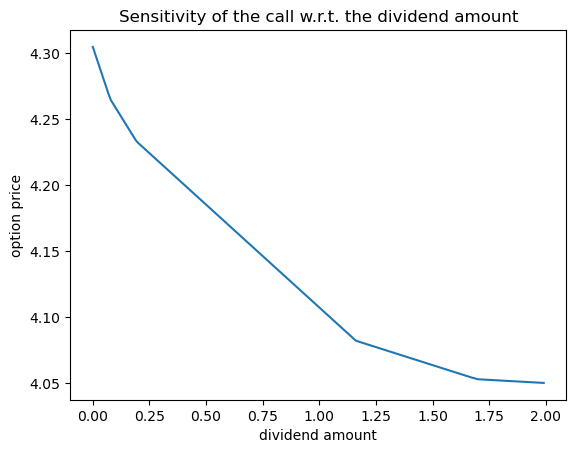

In [14]:
prices = []
for i in range(0, 200):
    divA = [i/100]
    prices.append(bt_american_with_div(True, underlying, strike, ttm, rf, divA, divT, ivol, N))

step = 0.01
p1 = bt_american_with_div(True, underlying, strike, ttm, rf, [0.88+step], divT, ivol, N)
p2 = bt_american_with_div(True, underlying, strike, ttm, rf, [0.88-step], divT, ivol, N)
print("the sensitivity at divAmt=$0.88: ", round((p1-p2)/(2*step), 4))

plt.plot(np.linspace(0, 1.99, 200), prices)
plt.xlabel("dividend amount")
plt.ylabel("option price")
plt.title("Sensitivity of the call w.r.t. the dividend amount")
plt.show()

the sensitivity at divAmt=$0.88:  0.4818


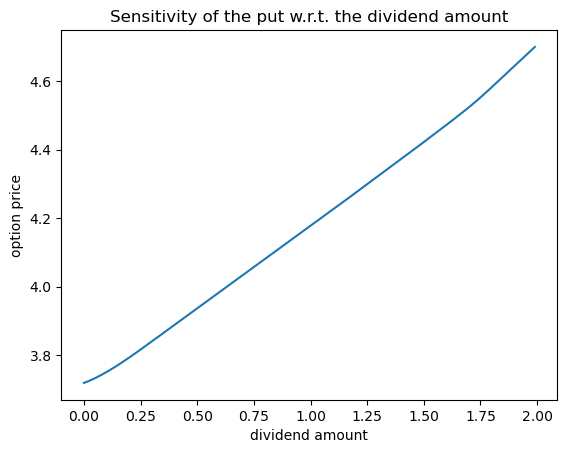

In [15]:
prices = []
for i in range(0, 200):
    divA = [i/100]
    prices.append(bt_american_with_div(False, underlying, strike, ttm, rf, divA, divT, ivol, N))

step = 0.01
p1 = bt_american_with_div(False, underlying, strike, ttm, rf, [0.88+step], divT, ivol, N)
p2 = bt_american_with_div(False, underlying, strike, ttm, rf, [0.88-step], divT, ivol, N)
print("the sensitivity at divAmt=$0.88: ", round((p1-p2)/(2*step), 4))

plt.plot(np.linspace(0, 1.99, 200), prices)
plt.xlabel("dividend amount")
plt.ylabel("option price")
plt.title("Sensitivity of the put w.r.t. the dividend amount")
plt.show()

### problem 2

In [31]:
def find_iv(call:bool, underlying, strike, ttm, rf, b, option_price, N=None, divAmts:list=[], divTimes:list=[], guess=0.2):
    if N is not None and len(divAmts) and len(divTimes):
        def equation(iv):
            return bt_american_with_div(call, underlying, strike, ttm, rf, divAmts, divTimes, iv, N) - option_price
    elif N is not None and not (len(divAmts) and len(divTimes)):
        def equation(iv):
            return bt_american(call, underlying, strike, ttm, rf, b, iv, N) - option_price
    else:
        def equation(iv):
            return gbsm(call, underlying, strike, ttm, rf, b, iv) - option_price
    sol = fsolve(equation, guess)
    return float(sol)

In [32]:
portfolio_df = pd.read_csv('problem2.csv')
portfolio_df['ExpirationDate'] = pd.to_datetime(portfolio_df['ExpirationDate'])
prices_df = pd.read_csv("DailyPrices.csv")
prices_df['Date'] = pd.to_datetime(prices_df['Date'])

underlying = 151.03
rf = 0.0425
current = datetime.datetime(2023, 3, 3)
calendarDays = (datetime.datetime(2023, 12, 31) - datetime.datetime(2022, 12, 31)).days
divA = [1.]
div1 = datetime.datetime(2023, 3, 15)
divT = [(div1-current).days]

key = portfolio_df['Portfolio'].unique()
portfolios = {}
for i in range(key.size):
    portfolios[key[i]] = portfolio_df[portfolio_df['Portfolio'] == key[i]]

In [33]:
ap_returns = risk.return_calculate(prices_df, 'log')['AAPL']
ap_returns -= ap_returns.mean()

# simulate AAPL returns 10 days ahead with normal distribution
sim_times = 1_000
sd = sps.norm.fit(ap_returns)[1]
sim_10_ret = sps.norm.rvs(scale=sd, size=(sim_times, 10))

new_prices = underlying
for i in range(10):
    new_prices *= np.exp(sim_10_ret[:, i])

In [34]:
def delta_normal_VaR_ES(A, Q, delta, P, var):
    """
    in dollar, consider only one underlying price, assuming μ=0
    """
    PV = A@Q
    dR = P/PV * delta@Q
    sigma = np.sqrt(dR*var*dR)
    P_ret = sps.norm.rvs(scale=sigma,size=10_000)
    delta_VaR, delta_ES = risk.VaR_ES(P_ret)
    return PV*delta_VaR, PV*delta_ES

In [35]:
for k, v in portfolios.items():
    v.reset_index(inplace=True)
    current_value = v['Holding']@v['CurrentPrice']
    total_values = np.zeros(sim_times)
    delta = np.ones(v.shape[0])
    for i in range(v.shape[0]):
        if v['Type'][i] == 'Option':
            if v['OptionType'][i] == 'Call':
                call = True
            elif v['OptionType'][i] == 'Put':
                call = False
            else:
                raise ValueError("OptionType must be Call or Put")

            ttm = (v['ExpirationDate'][i] - current).days / calendarDays
            N = (v['ExpirationDate'][i] - current).days
            iv = find_iv(call, underlying, v['Strike'][i], ttm, rf, rf, v['CurrentPrice'][i], N, divA, divT)
            ttm2 = ((v['ExpirationDate'][i] - current).days - 10) / calendarDays
            N2 = (v['ExpirationDate'][i] - current).days-10
            divT2 = [x-10 for x in divT]
            prices = np.array([bt_american_with_div(call, x, v['Strike'][i], ttm2, rf, divA, divT2, iv, N2) for x in new_prices])

            greeks = Greeks(call, underlying, v['Strike'][i], ttm2, rf, rf, iv, N2, divA, divT2)
            delta[i] = greeks.delta_finite_dif(1.)
        elif v['Type'][i] == 'Stock':
            prices = new_prices
            delta[i] = 1.
        else:
            raise ValueError("Type must be Option or Stock")

        values = prices * v['Holding'][i]
        total_values += values

    VaR, ES = risk.VaR_ES(total_values - current_value)
    delta_VaR, delta_ES = delta_normal_VaR_ES(v['CurrentPrice'], v['Holding'], delta, underlying, sd**2)

    print("For portfolio", k)
    print("PL mean:", round((total_values - current_value).mean(), 4))
    print("VaR and ES:", round(VaR, 4), round(ES, 4))
    print("delta normal VaR and ES:", round(delta_VaR, 4), round(delta_ES, 4))

For portfolio Straddle
PL mean: 1.6758
VaR and ES: 1.3353 1.366
delta normal VaR and ES: 0.4053 0.5082
For portfolio SynLong
PL mean: 0.4827
VaR and ES: 16.2335 19.3992
delta normal VaR and ES: 5.6162 6.9695
For portfolio CallSpread
PL mean: 0.0232
VaR and ES: 3.7367 4.0183
delta normal VaR and ES: 1.5768 1.9981
For portfolio PutSpread
PL mean: 0.2108
VaR and ES: 2.7786 2.8662
delta normal VaR and ES: 1.4852 1.8527
For portfolio Stock
PL mean: 1.0272
VaR and ES: 15.1176 18.0711
delta normal VaR and ES: 5.6105 6.992
For portfolio Call 
PL mean: 1.0792
VaR and ES: 5.8636 6.1831
delta normal VaR and ES: 2.98 3.7085
For portfolio Put 
PL mean: 0.5965
VaR and ES: 4.5542 4.6663
delta normal VaR and ES: 2.6322 3.2616
For portfolio CoveredCall
PL mean: -0.1089
VaR and ES: 11.3826 14.2001
delta normal VaR and ES: 3.2782 4.1031
For portfolio ProtectedPut
PL mean: 1.5485
VaR and ES: 7.2001 7.6135
delta normal VaR and ES: 3.6971 4.6728


### problem 3

In [36]:
symbols = ['AAPL', 'META', 'UNH', 'MA', 'MSFT', 'NVDA', 'HD', 'PFE', 'AMZN', 'BRK-B', 'PG', 'XOM', 'TSLA', 'JPM', 'V', 'DIS', 'GOOGL', 'JNJ', 'BAC', 'CSCO']
returns_df = risk.return_calculate(prices_df, 'log')[symbols]
momentum_df = pd.read_csv('F-F_Momentum_Factor_daily.CSV')
momentum_df['Date'] = pd.to_datetime(momentum_df['Date'], format='%Y%m%d')
momentum_df.set_index('Date', inplace=True)
factors3_df = pd.read_csv('F-F_Research_Data_Factors_daily.CSV')
factors3_df['Date'] = pd.to_datetime(factors3_df['Date'], format='%Y%m%d')
factors3_df.set_index('Date', inplace=True)

In [37]:
returns_10_years = pd.DataFrame()
for col in returns_df.columns:
    # fit data into 4 factor model
    X = pd.concat([factors3_df['2022-02-15':'2023-01-31'], momentum_df['2022-02-15':'2023-01-31']], axis=1).drop('RF', axis=1)/100
    y = returns_df['2022-02-15':'2023-01-31'][col]-factors3_df['2022-02-15':'2023-01-31']['RF']
    regr = linear_model.LinearRegression()
    regr.fit(X, y)

    # calculate the expected daily return based on past 10 years factor returns
    factors4 = pd.concat([factors3_df['2013-01-01':'2022-12-31'][['Mkt-RF', 'SMB', 'HML']], momentum_df['2013-01-01':'2022-12-31']['Mom   ']], axis=1)
    returns_10_years[col] = regr.intercept_ + factors4@regr.coef_ + factors3_df['2013-01-01':'2022-12-31']['RF']

In [38]:
# resample to get the annual average returns
annual_return = returns_10_years.resample('Y').mean()
er = annual_return.mean()
covar = annual_return.cov()

In [39]:
def optimize_risk(er, covar, R):
    objective = lambda w: w.T@covar@w
    x0 = [1/3] * er.size
    bnds = [(0, None)] * er.size
    constraint1 = lambda w: sum(w) - 1
    constraint2 = lambda w: w@er - R
    cons = ({'type': 'eq', 'fun': constraint1}, {'type': 'eq', 'fun': constraint2})
    result = minimize(objective, x0, bounds=bnds, constraints=cons)
    weight = result.x
    riskk = weight.T@covar@weight
    return weight, riskk

In [40]:
rets = []
weights = []
risks = []
SP = []
for r in range(25, 86):
    weight, riskk = optimize_risk(er, covar, r/1000)
    rets.append(r/1000)
    weights.append(weight)
    risks.append(riskk)
    SP.append((r/1000-rf)/riskk)

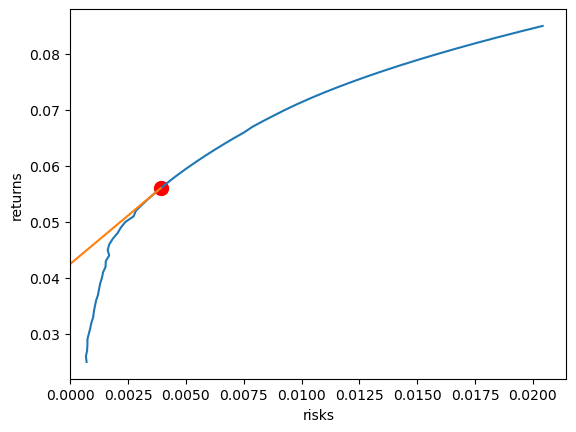

In [41]:
# efficient frontier
plt.plot(risks, np.linspace(0.025, 0.085, 61))
plt.xlabel("risks")
plt.ylabel("returns")

# super efficient portfolio
maxidx = np.argmax(np.array(SP))
maxSP_ret = rets[maxidx]
maxSP_risk = risks[maxidx]
plt.scatter(maxSP_risk, maxSP_ret, color='red', s=100, marker='o')

# CML
plt.plot([0, maxSP_risk], [rf, maxSP_ret])
plt.xlim((0, None))
plt.show()

In [46]:
weights[maxidx] = [0 if x<1e-8 else x for x in weights[maxidx]]
print("super efficient portfolio")
print("weights", [round(x, 4) for x in weights[maxidx]])
print("return", maxSP_ret)
print("risk", maxSP_risk)
print("shape ratio", SP[maxidx])

super efficient portfolio
weights [0.0982, 0, 0.25, 0, 0, 0.1954, 0, 0, 0, 0, 0, 0.4563, 0, 0, 0, 0, 0, 0, 0, 0]
return 0.056
risk 0.0039024594582645726
shape ratio 3.459356886183633


In [47]:
symbols

['AAPL',
 'META',
 'UNH',
 'MA',
 'MSFT',
 'NVDA',
 'HD',
 'PFE',
 'AMZN',
 'BRK-B',
 'PG',
 'XOM',
 'TSLA',
 'JPM',
 'V',
 'DIS',
 'GOOGL',
 'JNJ',
 'BAC',
 'CSCO']